[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yohoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yohoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\yohoh\AppData\Local\Temp\ipykernel_10704\2394073317.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


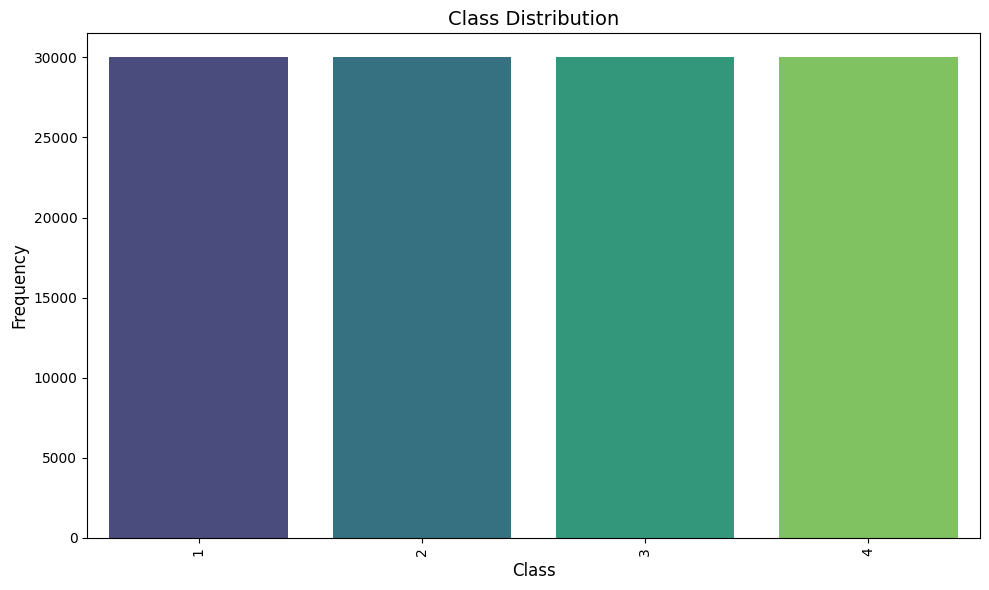

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

data_train = pd.read_csv('dataset/train.csv')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    text = text.lower()
    
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

data_train['Description'] = data_train['Description'].apply(clean_text)


class_counts = data_train['Class Index'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.title('Class Distribution', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


In [3]:
import torch # type: ignore
import numpy as np # type: ignore
import random
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

    os.environ["PYTHONHASHSEED"] = str(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

In [4]:
from sklearn.utils import shuffle # type: ignore

def create_binary_df(df1, df2, label1=0, label2=1, random_state=42):
    df1 = df1.copy()
    df2 = df2.copy()
    df1['label'] = label1
    df2['label'] = label2
    combined = pd.concat([df1, df2], ignore_index=True)
    combined = shuffle(combined, random_state=random_state)
    return combined


In [5]:
from sklearn.model_selection import train_test_split


class_dfs_train = {
    "World": data_train[data_train["Class Index"] == 1],
    "Sports": data_train[data_train["Class Index"] == 2],
    "Business": data_train[data_train["Class Index"] == 3],
    "Sci/Tech": data_train[data_train["Class Index"] == 4]
}

class_dfs_test = {
    "World": data_test[data_test["Class Index"] == 1],
    "Sports": data_test[data_test["Class Index"] == 2],
    "Business": data_test[data_test["Class Index"] == 3],
    "Sci/Tech": data_test[data_test["Class Index"] == 4]
}

df_1_train = create_binary_df(class_dfs_train['World'], class_dfs_train['Sports'], label1=1, label2=2)
df_2_train = create_binary_df(class_dfs_train['World'], class_dfs_train['Business'], label1=1, label2=3)
df_3_train = create_binary_df(class_dfs_train['World'], class_dfs_train['Sci/Tech'], label1=1, label2=4)
df_4_train = create_binary_df(class_dfs_train['Sports'], class_dfs_train['Business'], label1=2, label2=3)
df_5_train = create_binary_df(class_dfs_train['Sports'], class_dfs_train['Sci/Tech'], label1=2, label2=4)
df_6_train = create_binary_df(class_dfs_train['Business'], class_dfs_train['Sci/Tech'], label1=3, label2=4)

df_1_test = create_binary_df(class_dfs_test['World'], class_dfs_test['Sports'], label1=1, label2=2)
df_2_test = create_binary_df(class_dfs_test['World'], class_dfs_test['Business'], label1=1, label2=3)
df_3_test = create_binary_df(class_dfs_test['World'], class_dfs_test['Sci/Tech'], label1=1, label2=4)
df_4_test = create_binary_df(class_dfs_test['Sports'], class_dfs_test['Business'], label1=2, label2=3)
df_5_test = create_binary_df(class_dfs_test['Sports'], class_dfs_test['Sci/Tech'], label1=2, label2=4)
df_6_test = create_binary_df(class_dfs_test['Business'], class_dfs_test['Sci/Tech'], label1=3, label2=4)

label_map = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Sci/Tech'
}

data_train['label'] = data_train['Class Index'].map(label_map)
data_test['label'] = data_test['Class Index'].map(label_map)

data_test.shape[0], data_train.shape[0]
data_test.head()


,Class Index,Title,Description,label
0,3,Fears for T N pension after talks,union representing worker turner newall say di...,Business
1,4,The Race is On: Second Private Team Sets Launc...,spacecom toronto canada secondteam rocketeers ...,Sci/Tech
2,4,Ky. Company Wins Grant to Study Peptides (AP),ap company founded chemistry researcher univer...,Sci/Tech
3,4,Prediction Unit Helps Forecast Wildfires (AP),ap barely dawn mike fitzpatrick start shift bl...,Sci/Tech
4,4,Calif. Aims to Limit Farm-Related Smog (AP),ap southern california smogfighting agency wen...,Sci/Tech


In [6]:
from sentence_transformers import SentenceTransformer # type: ignore

sbert_model = SentenceTransformer('distiluse-base-multilingual-cased', local_files_only=True)

def embed_df(df, text_column='Description'):
    vectors = sbert_model.encode(df[text_column].tolist(), show_progress_bar=True)
    return vectors


In [7]:
# 1. ikili set
X1_train = embed_df(df_1_train)
y1_train = df_1_train['label'].values
X1_test = embed_df(df_1_test)
y1_test = df_1_test['label'].values

# 2. ikili set
X2_train = embed_df(df_2_train)
y2_train = df_2_train['label'].values
X2_test = embed_df(df_2_test)
y2_test = df_2_test['label'].values

# 3. ikili set
X3_train = embed_df(df_3_train)
y3_train = df_3_train['label'].values
X3_test = embed_df(df_3_test)
y3_test = df_3_test['label'].values

# 4. ikili set
X4_train = embed_df(df_4_train)
y4_train = df_4_train['label'].values
X4_test = embed_df(df_4_test)
y4_test = df_4_test['label'].values

# 5. ikili set
X5_train = embed_df(df_5_train)
y5_train = df_5_train['label'].values
X5_test = embed_df(df_5_test)
y5_test = df_5_test['label'].values

# 6. ikili set
X6_train = embed_df(df_6_train)
y6_train = df_6_train['label'].values
X6_test = embed_df(df_6_test)
y6_test = df_6_test['label'].values

X_total_train = embed_df(data_train)
y_total_train = data_train['label'].values
X_total_test = embed_df(data_test)
y_total_test = data_test['label'].values


Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

In [8]:
from torch import nn

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim=768, num_heads=3):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.heads = nn.ModuleList([
            nn.Linear(128, 1) for _ in range(num_heads)
        ])

    def forward(self, x):
        shared = self.shared_layers(x)
        return [head(shared) for head in self.heads]


def train_mode_with_bert_embeddings(
    X, y,
    input_dim=768,
    epochs=10,
    lr=1e-4,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    y = (y > y.min()).astype(np.int64)  # Binary
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = BinaryClassifier(input_dim=input_dim).to(device)
    model.apply(init_weights)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

    return model


In [37]:
model_1 = train_mode_with_bert_embeddings(input_dim=X1_train.shape[1], X=X1_train, y=y1_train, epochs=30)
model_2 = train_mode_with_bert_embeddings(input_dim=X2_train.shape[1], X=X2_train, y=y2_train, epochs=30) 
model_3 = train_mode_with_bert_embeddings(input_dim=X3_train.shape[1],X=X3_train, y=y3_train, epochs=30) 
model_4 = train_mode_with_bert_embeddings(input_dim=X4_train.shape[1], X=X4_train, y=y4_train, epochs=25) 
model_5 = train_mode_with_bert_embeddings(input_dim=X5_train.shape[1],X=X5_train, y=y5_train, epochs=30) 
model_6 = train_mode_with_bert_embeddings(input_dim=X6_train.shape[1],X=X6_train, y=y6_train, epochs=40) 


Epoch 1/30 - Loss: 0.1483
Epoch 2/30 - Loss: 0.1115
Epoch 3/30 - Loss: 0.0969
Epoch 4/30 - Loss: 0.0890
Epoch 5/30 - Loss: 0.0824
Epoch 6/30 - Loss: 0.0752
Epoch 7/30 - Loss: 0.0681
Epoch 8/30 - Loss: 0.0633
Epoch 9/30 - Loss: 0.0574
Epoch 10/30 - Loss: 0.0520
Epoch 11/30 - Loss: 0.0499
Epoch 12/30 - Loss: 0.0451
Epoch 13/30 - Loss: 0.0425
Epoch 14/30 - Loss: 0.0401
Epoch 15/30 - Loss: 0.0355
Epoch 16/30 - Loss: 0.0363
Epoch 17/30 - Loss: 0.0329
Epoch 18/30 - Loss: 0.0314
Epoch 19/30 - Loss: 0.0288
Epoch 20/30 - Loss: 0.0275
Epoch 21/30 - Loss: 0.0253
Epoch 22/30 - Loss: 0.0239
Epoch 23/30 - Loss: 0.0225
Epoch 24/30 - Loss: 0.0220
Epoch 25/30 - Loss: 0.0202
Epoch 26/30 - Loss: 0.0197
Epoch 27/30 - Loss: 0.0186
Epoch 28/30 - Loss: 0.0175
Epoch 29/30 - Loss: 0.0177
Epoch 30/30 - Loss: 0.0159
Epoch 1/30 - Loss: 0.2309
Epoch 2/30 - Loss: 0.1817
Epoch 3/30 - Loss: 0.1645
Epoch 4/30 - Loss: 0.1507
Epoch 5/30 - Loss: 0.1392
Epoch 6/30 - Loss: 0.1323
Epoch 7/30 - Loss: 0.1237
Epoch 8/30 - Loss

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1900
           1       0.97      0.97      0.97      1900

    accuracy                           0.97      3800
   macro avg       0.97      0.97      0.97      3800
weighted avg       0.97      0.97      0.97      3800



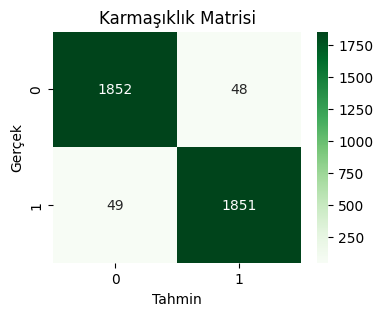

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1900
           1       0.95      0.95      0.95      1900

    accuracy                           0.95      3800
   macro avg       0.95      0.95      0.95      3800
weighted avg       0.95      0.95      0.95      3800



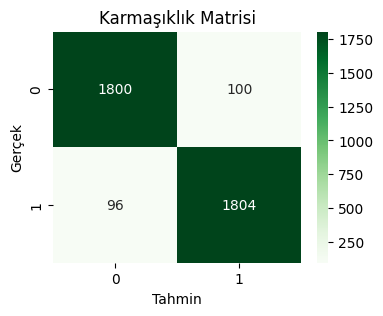

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1900
           1       0.96      0.95      0.96      1900

    accuracy                           0.96      3800
   macro avg       0.96      0.96      0.96      3800
weighted avg       0.96      0.96      0.96      3800



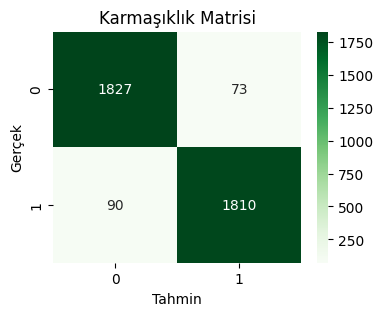

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1900
           1       0.99      0.98      0.98      1900

    accuracy                           0.98      3800
   macro avg       0.98      0.98      0.98      3800
weighted avg       0.98      0.98      0.98      3800



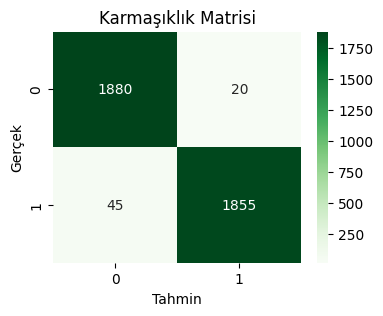

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1900
           1       0.98      0.98      0.98      1900

    accuracy                           0.98      3800
   macro avg       0.98      0.98      0.98      3800
weighted avg       0.98      0.98      0.98      3800



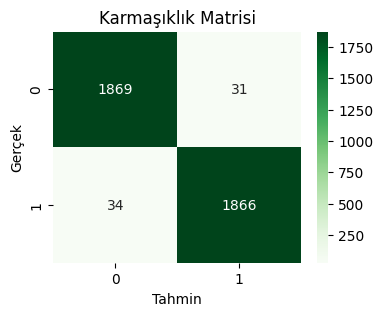

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1900
           1       0.91      0.91      0.91      1900

    accuracy                           0.91      3800
   macro avg       0.91      0.91      0.91      3800
weighted avg       0.91      0.91      0.91      3800



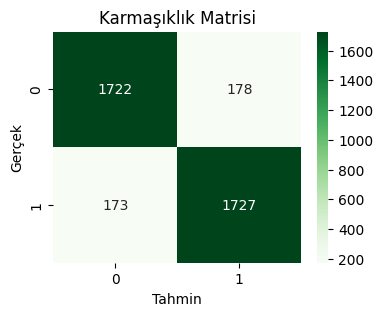

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
import seaborn as sns # type: ignore

def evaluate_binary_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_tensor = torch.tensor((y_test > y_test.min()).astype(np.int64)).to(device)  

        preds_proba = model(X_tensor).cpu().numpy()
        preds = (preds_proba > 0.5).astype(int).flatten()

    print(classification_report(y_tensor.cpu().numpy(), preds))
    cm = confusion_matrix(y_tensor.cpu().numpy(), preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    plt.title('Karmaşıklık Matrisi')
    plt.show()


evaluate_binary_model(model_1, X1_test, y1_test)
evaluate_binary_model(model_2, X2_test, y2_test)
evaluate_binary_model(model_3, X3_test, y3_test)
evaluate_binary_model(model_4, X4_test, y4_test)
evaluate_binary_model(model_5, X5_test, y5_test)
evaluate_binary_model(model_6, X6_test, y6_test)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MetaModel(nn.Module):
    def __init__(self, input_dim=6, num_classes=4):
        super(MetaModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), 
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes) 
        )

    def forward(self, x):
        return self.model(x)

def train_meta_model(X, y, epochs=10, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = MetaModel(input_dim=X.shape[1], num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)

            preds = model(xb)  
            loss = criterion(preds, yb) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

    return model


In [ ]:
def get_ensemble_predictions(models, X, device='cuda' if torch.cuda.is_available() else 'cpu'):
    preds = []
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_tensor)
            pred_binary = (pred > 0.5).float()
            preds.append(pred_binary.cpu().numpy())
    return np.concatenate(preds, axis=1)


In [ ]:
import numpy as np # type: ignore

X_all_train = np.concatenate([X1_train, X2_train, X3_train, X4_train], axis=0)
y_all_train = np.concatenate([y1_train, y2_train, y3_train, y4_train], axis=0)

X_all_train_unique, unique_indices = np.unique(X_all_train, axis=0, return_index=True)
y_all_train_unique = y_all_train[unique_indices]

X_all_test = np.concatenate([X1_test, X2_test, X3_test, X4_test], axis=0)
y_all_test = np.concatenate([y1_test, y2_test, y3_test, y4_test], axis=0)

X_all_test_unique, unique_indices_test = np.unique(X_all_test, axis=0, return_index=True)
y_all_test_unique = y_all_test[unique_indices_test]

ensemble_preds_train = get_ensemble_predictions(
    [model_1, model_2, model_3, model_4, model_5, model_6],
    X_total_train,
)



In [ ]:
reverse_label_map = {v: k for k, v in label_map.items()}

y_total_train = np.array([reverse_label_map[label] for label in y_total_train])
y_total_test = np.array([reverse_label_map[label] for label in y_total_test])

y_total_train = y_total_train - 1
y_total_test = y_total_test - 1


y_total_train, y_total_test

In [ ]:
final_model = train_meta_model(ensemble_preds_train, y_total_train, epochs=30)


Epoch 1/30 - Loss: 0.0817
Epoch 2/30 - Loss: 0.0391
Epoch 3/30 - Loss: 0.0384
Epoch 4/30 - Loss: 0.0383
Epoch 5/30 - Loss: 0.0376
Epoch 6/30 - Loss: 0.0374
Epoch 7/30 - Loss: 0.0372
Epoch 8/30 - Loss: 0.0367
Epoch 9/30 - Loss: 0.0361
Epoch 10/30 - Loss: 0.0360
Epoch 11/30 - Loss: 0.0367
Epoch 12/30 - Loss: 0.0365
Epoch 13/30 - Loss: 0.0356
Epoch 14/30 - Loss: 0.0355
Epoch 15/30 - Loss: 0.0352
Epoch 16/30 - Loss: 0.0350
Epoch 17/30 - Loss: 0.0353
Epoch 18/30 - Loss: 0.0355
Epoch 19/30 - Loss: 0.0350
Epoch 20/30 - Loss: 0.0352
Epoch 21/30 - Loss: 0.0351
Epoch 22/30 - Loss: 0.0352
Epoch 23/30 - Loss: 0.0347
Epoch 24/30 - Loss: 0.0346
Epoch 25/30 - Loss: 0.0348
Epoch 26/30 - Loss: 0.0343
Epoch 27/30 - Loss: 0.0344
Epoch 28/30 - Loss: 0.0343
Epoch 29/30 - Loss: 0.0351
Epoch 30/30 - Loss: 0.0345


              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1900
           1       0.95      0.96      0.96      1900
           2       0.87      0.86      0.87      1900
           3       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Kappa: 0.8707

Accuracy: 0.9030


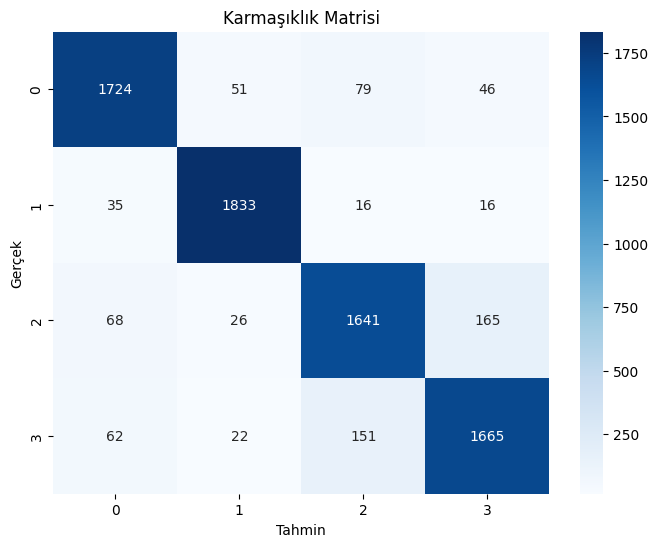

In [ ]:
import torch # type: ignore
import numpy as np # type: ignore


ensemble_inputs = get_ensemble_predictions(
    [model_1, model_2, model_3, model_4, model_5, model_6], 
    X_total_test
)



X_ens_tensor = torch.tensor(ensemble_inputs, dtype=torch.float32).to(device)

final_model.eval()
with torch.no_grad():
    y_pred_logits = final_model(X_ens_tensor)
    y_pred_proba = torch.softmax(y_pred_logits, dim=1).cpu().numpy()
    y_pred = np.argmax(y_pred_proba, axis=1)


from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore



print(classification_report(y_total_test, y_pred))
kappa = cohen_kappa_score(y_total_test, y_pred)
print(f"\nKappa: {kappa:.4f}")
accuracy = accuracy_score(y_total_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
cm = confusion_matrix(y_total_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karmaşıklık Matrisi')
plt.show()

